<a href="https://colab.research.google.com/github/jserrataylor/cursoAI/blob/main/Sistema_Recomendacion_Peliculas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recommender Systems tutorial

### Imports

In [1]:
import abc
import os
from zipfile import ZipFile
from pathlib import Path
import numpy as np
from scipy.sparse import coo_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
import requests
requests.packages.urllib3.disable_warnings()
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [3]:
pd.set_option('display.max_columns', None)

# Introduction


_"Recommender Systems (RS) are software tools and algorithms that suggest items that might be of interest to the users"_

![](https://miro.medium.com/proxy/1*UEIb9b7VT0u5NMBeZajxjg.png)
<sub>  [Fig 1. Item-item collaborative filtering](https://www.google.com/patents/US7113917)<sub>

![](https://miro.medium.com/max/3200/1*dMR3xmufnmKiw4crlisQUA.png)
<sub> Fig 2. [Netflix](https://www.netflixprize.com/). Everything is a recommendation! <sub>


Today, RS are an essential part of our daily life. Recommender Systems help us find effectively our favorite items to purchase, our friends on social networks, or our favorite movies to watch. In the so called _Zettabyte Era_ -- where we are surrounded by a massive volume of information--, a tool like RS able to deal with the problem of Information Overload seems to be mandatory.

Moreover, most giant companies like Google, Facebook, Amazon, Netflix or Spotify make use of RS in a wide range of applications,
including e-commerce, news or healthcare, with good reported revenues:


**Business value of recommenders**

_Netflix_
- “75% of what people watch is from some sort of recommendation”
- “the recommendations led to a measurable increase in user engagement”
- “the personalization and recommendation service helped to decrease customer
churn by several percentage points over the years “
- “we estimate the business value of recommendation and personalization
as more than 1 billion US dollar per year”

_Youtube_
- “60% of the clicks on the home screen are on the recommendations”

_Amazon_
- “About 35% of the sales originate from cross-sales (recommendation)” (2006)

_Google News_
- “Recommendations generates 38% more clickthrough”


**Collaborative Filtering.** A recommender system seeks to predict the "rating" or "preference" a user would give to an item.
Among the numerous techniques that have been proposed to tackle the recommendation problem, the so called *collaborative filtering* (CF) algorithms seem to be one of the most succesful.

CF is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). The underlying assumption of the collaborative filtering approach is that if a person A has the same opinion as a person B on an issue, A is more likely to have B's opinion on a different issue X than to have the opinion on X of a person chosen randomly.

<img src="https://courses.edx.org/c4x/BerkeleyX/CS100.1x/asset/Collaborative_filtering.gif" alt="collaborative filtering" style="float: right; width: 300px"/>

<sub> Fig 3. Example of user's preference prediction using collaborative filtering <sub>




In this notebook, we will implement two well known collaborative filtering based methods: on one hand, a standard matrix factorization technique; on the other, AutoRec, a neural network based recommender.

Simulations will be conducted on the _Movielens dataset_.

Models will be implemented in TensorFlow and keras.

<a name="outline"></a>
<a id='outline'></a>
## Outline
#### 1. [Movielens](#ml)
#### 2. [Matrix Factorization](#mf)
#### 2. [AutoRec](#autorec)


***
<a name="ml"></a>
<a id='ml'></a>
## [1. Movielens](#outline)

MovieLens dataset consists of:
* 1000209 ratings (1-5) from 6040 users on 3900 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)

The data was collected through the [MovieLens](https://grouplens.org/datasets/movielens/) [website](https://movielens.org). This data has been cleaned up - users
who had less than 20 ratings or did not have complete demographic
information were removed from this data set.

You can download the dataset [here](https://files.grouplens.org/datasets/movielens/ml-1m.zip).

In [4]:
# Download the actual data from http://files.grouplens.org/datasets/movielens/ml-1m.zip

movielens_data_file_url = \
  "https://files.grouplens.org/datasets/movielens/ml-1m.zip"


movielens_zipped_file = tf.keras.utils.get_file("ml-1m.zip",
                                                movielens_data_file_url,
                                                extract=False)

keras_datasets_path = Path(movielens_zipped_file).parents[0]
movielens_dir = keras_datasets_path / "ml-1m"

# Only extract the data the first time the script is run.
if not movielens_dir.exists():
    with ZipFile(movielens_zipped_file, "r") as zip:
        # Extract files
        print("Extracting all the files now...")
        zip.extractall(path=keras_datasets_path)
        print("Done!")

5917549/5917549 [==============================] - 1s 0us/step
Extracting all the files now...
Done!


Take a look at the readme file to get a clearer idea about the information available in the tar file:

In [5]:
# take a look at the readme file

readme = os.path.join(movielens_dir, "README")
!cat $readme

SUMMARY

These files contain 1,000,209 anonymous ratings of approximately 3,900 movies 
made by 6,040 MovieLens users who joined MovieLens in 2000.

USAGE LICENSE

Neither the University of Minnesota nor any of the researchers
involved can guarantee the correctness of the data, its suitability
for any particular purpose, or the validity of results based on the
use of the data set.  The data set may be used for any research
purposes under the following conditions:

     * The user may not state or imply any endorsement from the
       University of Minnesota or the GroupLens Research Group.

     * The user must acknowledge the use of the data set in
       publications resulting from the use of the data set
       (see below for citation information).

     * The user may not redistribute the data without separate
       permission.

     * The user may not use this information for any commercial or
       revenue-bearing purposes without first obtaining permission
       from a facult

In order to learn the data structure and get familiar with the data, let us compute the most rated movies (what movies are popular in the dataset?)

In [6]:
# read data

columns = ['user_id', 'item_id', 'rating', 'timestamp']
movielens_file = os.path.join(movielens_dir, "ratings.dat")
df = pd.read_csv(movielens_file, sep='::', names=columns)
print('There are %s users, %s itmes and %s pairs in the dataset' \
      %(df.user_id.unique().shape[0], df.item_id.unique().shape[0], df.shape[0]))
df.head()

<ipython-input-6-a9498da1501f>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(movielens_file, sep='::', names=columns)


There are 6040 users, 3706 itmes and 1000209 pairs in the dataset


,user_id,item_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


The correspondance between titles and ids is stored in the u.item file

In [7]:
items_id_file = os.path.join(movielens_dir, "movies.dat")
!head $items_id_file

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance
4::Waiting to Exhale (1995)::Comedy|Drama
5::Father of the Bride Part II (1995)::Comedy
6::Heat (1995)::Action|Crime|Thriller
7::Sabrina (1995)::Comedy|Romance
8::Tom and Huck (1995)::Adventure|Children's
9::Sudden Death (1995)::Action
10::GoldenEye (1995)::Action|Adventure|Thriller


In [8]:
columns = ['item_id', 'movie_title', 'Genres']
df_item_info = pd.read_csv(items_id_file, sep='::', names=columns, encoding = "latin")
df_item_info = df_item_info[['item_id', 'movie_title']].drop_duplicates()
df_item_info.head()

<ipython-input-8-3246c5f0f0b0>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df_item_info = pd.read_csv(items_id_file, sep='::', names=columns, encoding = "latin")


,item_id,movie_title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [9]:
# check uniques

len(df_item_info), len(df_item_info.item_id.unique()), len(df_item_info.movie_title.unique())

(3883, 3883, 3883)

In [10]:
# get most rated movies

mostRated = df.groupby('item_id')['user_id'].count().reset_index()
mostRated.head()

,item_id,user_id
0,1,2077
1,2,701
2,3,478
3,4,170
4,5,296


In [11]:
# translate movie_id

mostRated = pd.merge(mostRated, df_item_info, on=['item_id'], how='inner').sort_values(by='user_id', ascending=False)
mostRated.head(10)

,item_id,user_id,movie_title
2651,2858,3428,American Beauty (1999)
253,260,2991,Star Wars: Episode IV - A New Hope (1977)
1106,1196,2990,Star Wars: Episode V - The Empire Strikes Back...
1120,1210,2883,Star Wars: Episode VI - Return of the Jedi (1983)
466,480,2672,Jurassic Park (1993)
1848,2028,2653,Saving Private Ryan (1998)
575,589,2649,Terminator 2: Judgment Day (1991)
2374,2571,2590,"Matrix, The (1999)"
1178,1270,2583,Back to the Future (1985)
579,593,2578,"Silence of the Lambs, The (1991)"


Now that we are familiar with the data structure, let's prepare training and test data for subsequent analysis:

In [12]:
# train data
train, test = train_test_split(df, test_size=0.2)

# users, items and pairs
df_users = train.drop_duplicates(subset=['user_id'])[['user_id']]
df_users['user'] = np.arange(len(df_users))
df_items = train.drop_duplicates(subset=['item_id'])[['item_id']]
df_items['item'] = np.arange(len(df_items))
num_users = len(df_users)
num_items = len(df_items)
num_pairs = train.shape[0]
print('There are %s users, %s items and %s pairs in the train set' \
      %(num_users, num_items, num_pairs))

# new ids
train = pd.merge(train, df_users, on=['user_id'])
train = pd.merge(train, df_items, on=['item_id'])

# get x, y values
x_train, y_train = train[['user', 'item']], train[['rating']].astype(float)

There are 6040 users, 3683 items and 800167 pairs in the train set


In [13]:
# test data
test = pd.merge(test, df_users, on=['user_id'], how='inner')
test = pd.merge(test, df_items, on=['item_id'], how='inner')
print('There are %s users, %s items and %s pairs in the train set' \
      %(len(test['user_id'].unique()), len(test['item_id'].unique()), test.shape[0]))

# get x, y values
x_test, y_test = test[['user', 'item']], test[['rating']].astype(float)

There are 6032 users, 3446 items and 200013 pairs in the train set


***
<a name="mf"></a>
<a id='mf'></a>
## [2. Matrix Factorization](#outline)

Matrix factorization is a class of collaborative filtering models
which factorizes
the user-item interaction (or rating) matrix into the product of two lower-rank matrices (also called latent factors):

## $$r_{i,j} \approx {\bf U}_i\cdot{\bf P}_j^T$$

![](https://static.commonlounge.com/fp/600w/MybvxbBIIfovyMO1VlNoi2eUu1520501686_kc)

<sub> Fig 4. Matrix Factorization <sub>


We train the matrix factorization model by minimizing the mean squared error between predicted rating scores and real rating scores.  The objective function is defined as follows:

$$
\underset{\mathbf{P}, \mathbf{Q}, b}{\mathrm{argmin}} \sum_{(u, i) \in \mathcal{K}} \| \mathbf{r}_{ui} -
\hat{\mathbf{r}}_{ij} \|^2 + \lambda (\| \mathbf{U} \|^2 + \| \mathbf{P}
\|^2 + b_i^2 + b_j^2 )
$$

where

$$
\hat{\mathbf{r}}_{ij} = \mathbf{u}_i\mathbf{p}^\top_j + b_i + b_j
$$

is the predicted rating and
$\lambda$ denotes the regularization rate (used to avoid over-fitting).

The $(i, j)$ pairs for which $\mathbf{r}_{ij}$ is known are stored in the set
$\mathcal{K}$.

The model parameters can be learned with an optimization algorithm, such as Stochastic Gradient Descent and Adam.

Note how in the process of recovering non null values of $\mathbf{r}_{ij}$, we fill the missing entries of the input (ie, we densify the rating matrix!)

The steps to code the matrix factorization model are as follows:

- Map user ID to a "user vector" via an embedding matrix
- Map movie ID to a "movie vector" via an embedding matrix
- Compute the dot product between the user vector and movie vector, to obtain the a match score between the user and the movie (predicted rating).
Train the embeddings via gradient descent using all known user-movie pairs.

Time to code :)

In [14]:
class MatrixFactorization(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size, **kwargs):
        super(MatrixFactorization, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.user_embedding = tf.keras.layers.Embedding(
            self.num_users,
            embedding_size,
            #embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.user_bias = tf.keras.layers.Embedding(self.num_users, 1)
        self.item_embedding = tf.keras.layers.Embedding(
            self.num_items,
            embedding_size,
            #embeddings_initializer="he_normal",
            embeddings_regularizer=tf.keras.regularizers.l2(1e-6),
        )
        self.item_bias = tf.keras.layers.Embedding(self.num_items, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        output = dot_user_item + user_bias + item_bias
        return output

In [15]:
# Params

EMBEDDING_SIZE = 10

In [16]:
model = MatrixFactorization(num_users, num_items, EMBEDDING_SIZE)
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=tf.keras.optimizers.Adam(lr=1e-4))

In [17]:
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=30,
    verbose=1,
    validation_data=(x_test, y_test)
)

Epoch 1/30
12503/12503 [==============================] - 41s 3ms/step - loss: 1.9685 - val_loss: 1.8364
Epoch 2/30
12503/12503 [==============================] - 39s 3ms/step - loss: 0.9119 - val_loss: 1.8082
Epoch 3/30
12503/12503 [==============================] - 39s 3ms/step - loss: 0.9028 - val_loss: 1.7107
Epoch 4/30
12503/12503 [==============================] - 39s 3ms/step - loss: 0.9046 - val_loss: 1.6587
Epoch 5/30
12503/12503 [==============================] - 39s 3ms/step - loss: 0.9029 - val_loss: 1.5835
Epoch 6/30
12503/12503 [==============================] - 37s 3ms/step - loss: 0.9043 - val_loss: 1.5156
Epoch 7/30
12503/12503 [==============================] - 40s 3ms/step - loss: 0.9040 - val_loss: 1.4792
Epoch 8/30
12503/12503 [==============================] - 38s 3ms/step - loss: 0.9058 - val_loss: 1.4496
Epoch 9/30
12503/12503 [==============================] - 40s 3ms/step - loss: 0.9040 - val_loss: 1.4827
Epoch 10/30
12503/12503 [==============================

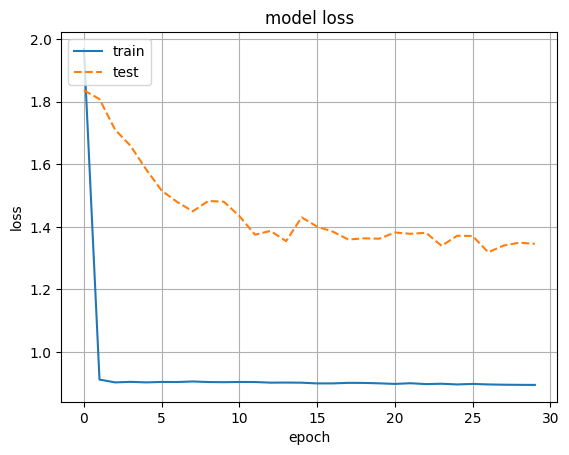

In [18]:
# Plot training loss

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"], '--')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.grid()
plt.show()

In [19]:
def recommend(user_id, train, test, df_items, df_aux):
  movies_watched_by_user = train[train.user == user_id]

  df_items_aux = df_items[['item']]
  df_items_aux['user'] = user_id
  movies_not_watched = pd.merge(df_items_aux, movies_watched_by_user, on=['user', 'item'], how='left')
  movies_not_watched = movies_not_watched[movies_not_watched.rating.isnull()][['user', 'item']]

  ratings = model.predict(movies_not_watched).flatten()
  movies_not_watched['predicted_rating'] = ratings
  top_ratings_items = movies_not_watched.sort_values(by='predicted_rating', ascending=False)

  print("Showing recommendations for user: {}".format(user_id))
  print("====" * 9)
  print("Movies with high ratings from user")
  print("----" * 8)

  movies_watched_by_user = pd.merge(movies_watched_by_user, df_aux, on=['item_id'])
  top_movies_user = movies_watched_by_user.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'movie_title']]
  print(top_movies_user.head(20))

  print("====" * 9)
  print("Ratings of movies watched in test")
  print("----" * 8)
  movies_watched_by_user_test = test[test.user == user_id]
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, df_aux, on=['item_id'])
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, movies_not_watched, on=['user', 'item'])
  movies_user_test = movies_watched_by_user_test.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'predicted_rating', 'movie_title']]
  print(movies_user_test.head(20))

  print("----" * 8)
  print("Top 10 movie recommendations")
  print("----" * 8)
  top_movies_recommended = pd.merge(top_ratings_items, df_items, on=['item'])
  top_movies_recommended = pd.merge(top_movies_recommended, df_aux, on=['item_id'])
  print(top_movies_recommended[['item', 'predicted_rating', 'movie_title']].head(20))


In [20]:
#Show top 10 movie recommendations to a user

user_id = test.user.sample(1).iloc[0]
recommend(user_id, train, test, df_items, df_item_info)

115/115 [==============================] - 0s 1ms/step
Showing recommendations for user: 5966
Movies with high ratings from user
--------------------------------
    user  item  rating                      movie_title
1   5966   545       5               October Sky (1999)
3   5966   521       4       Edward Scissorhands (1990)
5   5966  1347       4              Men in Black (1997)
8   5966   750       4            Grumpy Old Men (1993)
11  5966  1086       4                      Rudy (1993)
12  5966  1438       4            Bank Dick, The (1940)
0   5966   141       3                Casablanca (1942)
4   5966   361       3             Jurassic Park (1993)
9   5966   916       3       About Last Night... (1986)
10  5966  1071       3           Mission to Mars (2000)
13  5966   847       3          Grumpier Old Men (1995)
6   5966   270       2  Rescuers Down Under, The (1990)
7   5966  1897       2          Fatal Attraction (1987)
14  5966  2136       2        Angels and Insects (1995

__Extension__. + Contextual information
![](https://1.bp.blogspot.com/-ww8cKT3nIb8/X2pdWAWWNmI/AAAAAAAADl8/pkeFRxizkXYbDGbOcaAnZkorjEuqtrabgCLcBGAsYHQ/s0/TF%2BRecommenders%2B06.gif)

***
<a name="autorec"></a>
<a id='autorec'></a>
## [3. AutoRec](#outline)

One of the majors drawbacks of the previous model is its lack of nonlinearity. This fact prevents matrix factorization to identify complex
and intricate relationships between users and items.

In this section,
we introduce a nonlinear neural network collaborative filtering model: AutoRec.

In a nutshell, [AutoRec](https://users.cecs.anu.edu.au/~akmenon/papers/autorec/autorec-paper.pdf) is an autoencoder-based architecture. As such, AutoRec structure consists of an input layer, a hidden layer, and a reconstruction (output) layer. Hidden layer codes the inputs into a low dimensional representation. However and in constrast with traditional autoencoders, AutoRec focuses not only in the internal representation but also in the reconstruction step: it is during the reconstruction when missing entries of the rating matrix are filled.

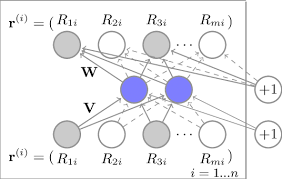

<sub>Figure 1: Item-based AutoRec model <sub>

Let $r_{:,i}$ denote the i th column of the rating matrix, where unknown ratings are set to zeros by default.

The neural architecture is defined as:

$$h(r_{:,i}) = f(W · g(V r_{:,i} + \mu) + b)$$

where $f(·)$ and $g(·)$ represent activation functions, W and V are weight matrices, $\mu$ and b are biases. $h(r_{:,i})$ is the reconstruction of the i
th column of the rating matrix.

The following objective function aims to minimize the reconstruction error:

$$
\underset{\mathbf{W},\mathbf{V},\mu, b}{\mathrm{argmin}} \sum_{i=1}^M{\parallel \mathbf{r}_{:,i} - h(\mathbf{r}_{:, i})\parallel_{\mathcal{O}}^2} +\lambda(\| \mathbf{W} \|_F^2 + \| \mathbf{V}\|_F^2)
$$

where  $\| \cdot \|_{\mathcal{O}}$  means only the contribution of observed ratings are considered, that is, only weights
that are associated with observed inputs are updated during back-propagation

In [21]:
class AutoRec(tf.keras.Model):
  def __init__(self, num_hidden, num_users, dropout=0.05, reg_enc=1e-3, reg_dec=1e-3):
    super(AutoRec, self).__init__()
    self.encoder = tf.keras.layers.Dense(num_hidden, activation='sigmoid',
                                         use_bias=True,
                                         kernel_regularizer=tf.keras.regularizers.l2(reg_enc))
    self.decoder = tf.keras.layers.Dense(num_users, use_bias=True,
                                         kernel_regularizer=tf.keras.regularizers.l2(reg_dec))
    self.dropout = tf.keras.layers.Dropout(dropout)

  def call(self, input, training=None):
    hidden = self.dropout(self.encoder(input))
    pred = self.decoder(hidden)
    return pred

In [22]:
# Custom metric

def autorec_rmse(y_true, y_pred):
  y_mask = tf.math.sign(y_true)
  squared_difference = tf.square(y_true - y_pred * y_mask)
  return tf.sqrt(tf.reduce_sum(squared_difference, axis=-1) / tf.math.maximum(tf.reduce_sum(y_mask, axis=-1), 1))


In [23]:
# data

ae_data_train = train.groupby('user').agg({'item': list, 'rating': list}).reset_index()
ae_data_train['input'] = ae_data_train.apply(lambda x: np.squeeze(coo_matrix((x[2], (np.zeros_like(x[1]), x[1])),
                                                                  shape=(1, num_items)).toarray()),
                                             axis=1)
ae_data_train.head()

,user,item,rating,input
0,0,"[0, 1403, 443, 174, 548, 2161, 1744, 233, 1406...","[4, 3, 4, 4, 3, 2, 4, 4, 2, 4, 2, 4, 5, 4, 3, ...","[4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[233, 331, 247, 128, 890, 1113, 178, 1231, 229...","[2, 3, 4, 4, 4, 1, 4, 1, 4, 4, 4, 2, 3, 4, 5, ...","[0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[443, 174, 2, 423, 251, 266, 169, 141, 130, 72...","[5, 5, 5, 5, 4, 3, 5, 5, 4, 4, 5, 5, 4, 5, 5, ...","[0, 0, 5, 0, 0, 5, 5, 4, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,"[0, 443, 174, 233, 1406, 179, 1937, 293, 731, ...","[3, 5, 4, 3, 5, 4, 2, 2, 4, 3, 3, 5, 2, 5, 4, ...","[3, 5, 0, 4, 4, 3, 3, 4, 0, 0, 2, 0, 0, 0, 0, ..."
4,4,"[0, 443, 548, 1224, 179, 1167, 735, 293, 731, ...","[5, 5, 3, 5, 4, 2, 1, 2, 4, 4, 1, 1, 5, 5, 3, ...","[5, 0, 0, 0, 1, 5, 2, 4, 0, 0, 0, 0, 0, 0, 1, ..."


In [24]:
x_train_autorec = ae_data_train.values[:, 3]
x_train_autorec = np.stack(x_train_autorec).astype(float)
x_train_autorec

array([[4., 0., 4., ..., 0., 0., 0.],
       [0., 5., 0., ..., 0., 0., 0.],
       [0., 0., 5., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
# test
ae_data_test = test.groupby('user').agg({'item': list, 'rating': list}).reset_index()
ae_data_test['input'] = ae_data_test.apply(lambda x: np.squeeze(coo_matrix((x[2], (np.zeros_like(x[1]), x[1])),
                                                                shape=(1, num_items)).toarray()),
                                           axis=1)

ae_data_test_aux = pd.merge(ae_data_train, ae_data_test, on=['user'], how='inner')
x_test_autorec = np.stack(ae_data_test_aux.values[:, -1]).astype(float)
x_test_autorec

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
# params
NUM_HIDDEN = 500
DROPOUT = 0.5
REG_ENC = 5e-4
REG_DEC = 5e-4

In [27]:
model = AutoRec(NUM_HIDDEN, num_items, DROPOUT, REG_ENC, REG_DEC)
model.compile(loss=autorec_rmse,
              optimizer=tf.keras.optimizers.Adam(lr=1e-4))

In [28]:
history = model.fit(
    x_train_autorec,
    x_train_autorec,
    batch_size=256,
    epochs=1000,
    verbose=1,
    validation_data=(x_test_autorec, x_test_autorec))

Epoch 1/1000
24/24 [==============================] - 6s 211ms/step - loss: 2.5416 - val_loss: 1.7942
Epoch 2/1000
24/24 [==============================] - 8s 314ms/step - loss: 1.4931 - val_loss: 1.5076
Epoch 3/1000
24/24 [==============================] - 4s 179ms/step - loss: 1.3222 - val_loss: 1.3964
Epoch 4/1000
24/24 [==============================] - 4s 181ms/step - loss: 1.2452 - val_loss: 1.3364
Epoch 5/1000
24/24 [==============================] - 6s 240ms/step - loss: 1.2012 - val_loss: 1.2897
Epoch 6/1000
24/24 [==============================] - 4s 176ms/step - loss: 1.1739 - val_loss: 1.2635
Epoch 7/1000
24/24 [==============================] - 4s 177ms/step - loss: 1.1537 - val_loss: 1.2340
Epoch 8/1000
24/24 [==============================] - 6s 242ms/step - loss: 1.1379 - val_loss: 1.2194
Epoch 9/1000
24/24 [==============================] - 4s 178ms/step - loss: 1.1280 - val_loss: 1.2083
Epoch 10/1000
24/24 [==============================] - 4s 175ms/step - loss: 1.118

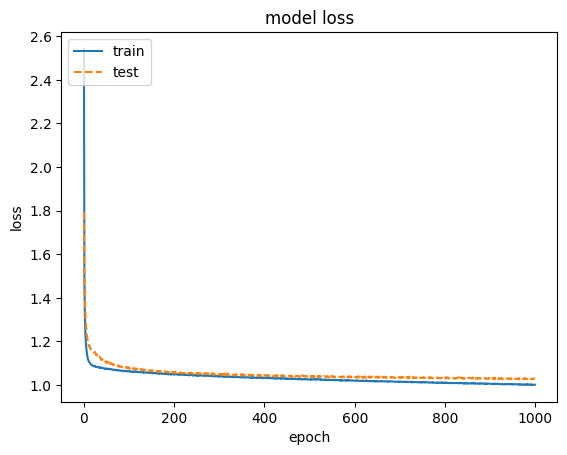

In [29]:
# Plot training loss

plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"], '--')
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [31]:
def recommend_autorec(user_id, train, test, df_items, df_aux, num_items):
  movies_watched_by_user = train[train.user == user_id]

  df_items_aux = df_items[['item']]
  df_items_aux['user'] = user_id
  movies_not_watched = pd.merge(df_items_aux, movies_watched_by_user, on=['user', 'item'], how='left')
  movies_not_watched = movies_not_watched[movies_not_watched.rating.isnull()][['user', 'item']]

  df_input = movies_watched_by_user.groupby('user').agg({'item': list, 'rating': list}).reset_index()
  df_input['input'] = df_input.apply(lambda x: np.squeeze(coo_matrix((x[2], (np.zeros_like(x[1]), x[1])),
                                                          shape=(1, num_items)).toarray()),
                                     axis=1)

  x = np.stack(df_input.values[:, -1]).astype(float)
  ratings = model.predict(x).flatten()
  ratings_items = pd.DataFrame({'item': np.arange(num_items), 'predicted_rating': ratings})
  ratings_items = pd.merge(ratings_items, movies_not_watched, on=['item'], how='left')
  top_ratings_items = ratings_items[ratings_items.user.notnull()] \
    .sort_values(by='predicted_rating', ascending=False)[['item', 'predicted_rating']]

  print("Showing recommendations for user: {}".format(user_id))
  print("====" * 9)
  print("Movies with high ratings from user")
  print("----" * 8)

  movies_watched_by_user = pd.merge(movies_watched_by_user, df_aux, on=['item_id'])
  top_movies_user = movies_watched_by_user.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'movie_title']]
  print(top_movies_user.head(20))

  print("====" * 9)
  print("Ratings of movies seen in test")
  print("----" * 8)
  movies_watched_by_user_test = test[test.user == user_id]
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, df_aux, on=['item_id'])
  movies_watched_by_user_test = pd.merge(movies_watched_by_user_test, ratings_items, on=['user', 'item'])
  movies_user_test = movies_watched_by_user_test.sort_values(by='rating', ascending=False)[['user', 'item', 'rating', 'predicted_rating', 'movie_title']]
  print(movies_user_test.head(20))

  print("----" * 8)
  print("Top 10 movie recommendations")
  print("----" * 8)
  top_movies_recommended = pd.merge(top_ratings_items, df_items, on=['item'])
  top_movies_recommended = pd.merge(top_movies_recommended, df_aux, on=['item_id'])
  print(top_movies_recommended[['item', 'predicted_rating', 'movie_title']].head(10))


In [32]:
#Show top 10 movie recommendations to a user

user_id = test.user.sample(1).iloc[0]
recommend_autorec(user_id, train, test, df_items, df_item_info, num_items)

1/1 [==============================] - 0s 153ms/step
Showing recommendations for user: 3000
Movies with high ratings from user
--------------------------------
     user  item  rating                                        movie_title
0    3000   443       5                            Schindler's List (1993)
57   3000   436       5  Star Wars: Episode VI - Return of the Jedi (1983)
116  3000   738       5                 Back to the Future Part III (1990)
109  3000   118       5                          Fifth Element, The (1997)
100  3000    61       5                                Forrest Gump (1994)
99   3000   207       5                         Maltese Falcon, The (1941)
98   3000   868       5                           Great Escape, The (1963)
96   3000    60       5                        Boat, The (Das Boot) (1981)
92   3000    47       5                                   Toy Story (1995)
89   3000   299       5                                   Apollo 13 (1995)
87   3000   630

### References

1. [Keras collaborative filtering example](https://keras.io/examples/structured_data/collaborative_filtering_movielens/)

2. [Tensorflow Recommenders](https://www.tensorflow.org/recommenders?hl=es-419)

3. [d2l book](https://d2l.ai/chapter_recommender-systems/index.html)